In [1]:
%matplotlib inline
import spacy
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from src import AddresslineTagger
from src import FeatureGeneration
from src.utility import jsonl_reader

I0725 00:12:14.381648 139624267507520 file_utils.py:41] PyTorch version 1.5.0+cu101 available.
I0725 00:12:15.131906 139624267507520 file_utils.py:57] TensorFlow version 2.2.0 available.


In [2]:
dataset = jsonl_reader('dataset/sample_dataset.jsonl')

In [5]:
# threshold = 1 means we will try to search vendor and buyer address in the full document
At = AddresslineTagger(dataset, threshold=1)
data = At.result.drop_duplicates(subset=['text'])
data.to_csv('dataset/supervised_dataset(full).csv', index = False)
data[['document_id', 'line_id', 'text', 'label',
       'class_2_target']].groupby('class_2_target').nunique()

I0725 00:12:24.101343 139624267507520 utils.py:129] Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
I0725 00:12:24.101797 139624267507520 utils.py:141] NumExpr defaulting to 8 threads.


,document_id,line_id,text,label,class_2_target
class_2_target,,,,,
addressline,105,53,486,3,1
non-addressline,105,61,3001,1,1


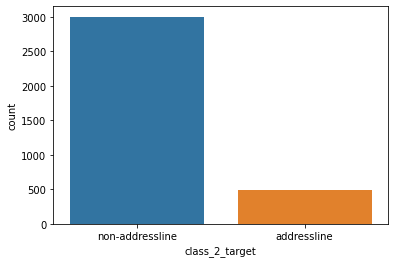

In [6]:
sns.countplot(data['class_2_target'],label="Count")
plt.show()

### Observation:
1. Above graph shows that data is highly imbalanced. But As we know that, most of the cases vendor name and buyer name is the top lines. Lets see if we tag the address lines from the top portion of the documents, we might reduce some address lines, but it helps us to balance the dataset.

### Next Step:
1. We will try to search vendor and buyer address in the top 40% of the document. So we will take the top 40% document as it is and if we find the address line is coming from the remaining portion then we will take only those additional addressline from the remaining sectionas well.

2. Questions:
    - Our goal here is to identify the given text has address or not? Above approch helps me to take all the address lines. But, Negative samples we are selecting from the top section of the document only which means Negative samples are baised.
    - Now, In future when New document will come, If we will pass the full line-wise data to the classification what can happen? Model can fail for the lines which are coming from the bottom section because thats going to be completely unknown text for the model.
    - In future, If we get document with new formats/templates, where address can be present at the bottom section of the document, then failure rate of addressline classification is going to be very high.
    - Rather than picking up the negative samples from the top section can we try picking up 40% non-address lines randomly.

In [7]:
# threshold = 0.4 means, from the all the negative samples, we will choose the 40% negative sample.
At = AddresslineTagger(dataset, threshold=0.40)
filter_data = At.result.drop_duplicates(subset=['text'])
filter_data.to_csv('dataset/supervised_dataset(pruned).csv', index = False) #save the dataset
filter_data[['document_id', 'line_id', 'text', 'label',
       'class_2_target']].groupby('class_2_target').nunique()

,document_id,line_id,text,label,class_2_target
class_2_target,,,,,
addressline,105,53,489,3,1
non-addressline,105,57,1424,1,1


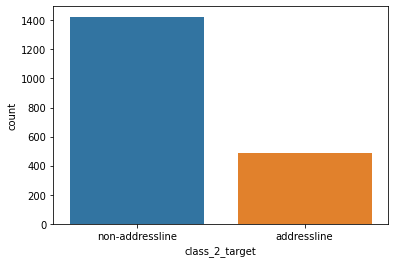

In [8]:
sns.countplot(filter_data['class_2_target'],label="Count")
plt.show()

so compared to the previous plot, as you see the data distrubution looks slightly better,not entirely balanced.but its much better